# Assignment 2: Restricted Boltzmann Machine

## Author: Fabrizio De Castelli

In [1]:
import os
import keras as K
from sklearn.model_selection import train_test_split

import numpy as np
np.random.seed(42)

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# ------- GLOBAL VARIABLES -------
# MNIST dataset
MNIST_TRAINING_IMAGES_PATH = "dataset/train-images.idx3-ubyte"
MNIST_TRAINING_LABELS_PATH = "dataset/train-labels.idx1-ubyte"
MNIST_TEST_IMAGES_PATH = "dataset/t10k-images.idx3-ubyte"
MNIST_TEST_LABELS_PATH = "dataset/t10k-labels.idx1-ubyte"


In [2]:
class RestrictedBoltzmannMachine:
    """
    Restricted Boltzmann Machine implementation.
    """
    
    def __init__(self, num_visible, num_hidden):
        self.num_visible = num_visible
        self.num_hidden = num_hidden
        # glorot initialization for weights
        self.weights = np.random.randn(num_hidden, num_visible) * np.sqrt(6 / (num_hidden + num_visible))
        # zeros initialization for biases
        self.hidden_bias = np.zeros((num_hidden, 1))
        self.visible_bias = np.zeros((num_visible, 1))
        self.energy_record = []
        self.average_energy_record = []
        self.learning_rate = 0.1
            
    @classmethod
    def from_components(cls, path):
        """
        Creates a RestrictedBoltzmannMachine instance from the components saved in a file.
        
        :param path: path to the file
        :return: an instance of RestrictedBoltzmannMachine
        """
        with np.load(path) as f:
            weights = f['weights']
            hidden_bias = f['hidden_bias']
            visible_bias = f['visible_bias']
        rmb = cls(weights.shape[1], weights.shape[0])
        rmb.weights = weights
        rmb.hidden_bias = hidden_bias
        rmb.visible_bias = visible_bias
        return rmb
    
    def contrastive_divergence(self, k, v0):
        """
        Performs k steps of the Contrastive Divergence algorithm.
        
        :param k: the number of steps
        :param v0: the visible input after binarization
        :return: the positive hidden probabilities, the reconstructed data and the negative hidden probabilities
        """

        positive_hidden_probabilities = None
        reconstructed_data = v0
        negative_hidden_probabilities = None
        
        for _ in range(k):
            
            # Positive phase
            positive_hidden_probabilities = self.sample_hidden(reconstructed_data) # [m, batch_size]
            positive_hidden_stochastic = RestrictedBoltzmannMachine.binarize(positive_hidden_probabilities) # [m, batch_size]
            data_reconstruction_probability = self.sample_visible(positive_hidden_stochastic) # [n, batch_size]
            
            # Negative phase
            reconstructed_data = RestrictedBoltzmannMachine.binarize(data_reconstruction_probability) # [n, batch_size]
            negative_hidden_probabilities = self.sample_hidden(reconstructed_data) # [m, batch_size]
            
        self.energy_record.append(self.energy(reconstructed_data, negative_hidden_probabilities))
        
        wake = np.dot(positive_hidden_probabilities, v0)
        dream = np.dot(negative_hidden_probabilities, reconstructed_data)
        
        dW = wake - dream
        dhb = (positive_hidden_probabilities - negative_hidden_probabilities).sum(axis=1).reshape(-1, 1)
        dvb = (v0 - reconstructed_data).sum(axis=0).reshape(-1, 1)
        
        error = np.mean(np.square(v0 - reconstructed_data))
        
        self.weights = self.weights + self.learning_rate * dW
        self.hidden_bias = self.hidden_bias + self.learning_rate * dhb 
        self.visible_bias = self.visible_bias + self.learning_rate * dvb 
        
        return error, reconstructed_data
        
    def fit(self, data, epochs, k=1, learning_rate=0.1, batch_size=None, verbose=False):
        """
        Fits the RBM to the data.
        
        :param data: the input examples
        :param epochs: number of epochs
        :param k: the number of steps in the contrastive divergence
        :param learning_rate: the learning rate
        :param batch_size: the batch size
        :param verbose: whether to print the error at each epoch
        """
        
        if batch_size is None:
            batch_size = len(data)
        error = 0
        
        self.learning_rate = learning_rate / batch_size
        
        for epoch in range(epochs):
        
            np.random.shuffle(data)
            self.energy_record = []
            
            for i in range(len(data) // batch_size):
                
                batch = data[i * batch_size: (i + 1) * batch_size]
                binarized_inputs = RestrictedBoltzmannMachine.binarize(batch)
                error, _ = self.contrastive_divergence(k, binarized_inputs)
                
            self.average_energy_record.append(np.mean(self.energy_record))
            
            if verbose:
                print(f'Epoch: {epoch + 1}, Error: {error}, Average Energy: {self.average_energy_record[-1]}')
                
                
    def energy(self, v, h):
        """
        Computes the energy of the RBM.
        
        :param v: the visible layer
        :param h: the hidden layer
        :return: the energy
        """
        return -np.dot(v, self.visible_bias).sum() - np.dot(h.T, self.hidden_bias).sum() - np.dot(np.dot(v, self.weights.T), h).sum()
            
    @staticmethod
    def sigmoid(x):
        return 1 / (1 + np.exp(-x))
    
    def sample_hidden(self, visible):
        """
        Sample the hidden layer given the visible layer.
        
        :param visible: the visible layer
        :return: the hidden activations
        """
        return RestrictedBoltzmannMachine.sigmoid(np.add(np.dot(self.weights, visible.T), self.hidden_bias))
    
    def sample_visible(self, hidden):
        """
        Sample the visible layer given the hidden layer.
        
        :param hidden: the hidden layer
        :return: the visible activations
        """
        return RestrictedBoltzmannMachine.sigmoid(np.add(np.dot(hidden.T, self.weights), self.visible_bias.T))
    
    @staticmethod
    def binarize(data):
        return (data > np.random.rand(*data.shape)).astype(int)
    
    
    def predict_hidden(self, data):
        """
        Predicts the hidden layer activations given the input data.
        
        :param data: the input data
        :return: the hidden layer activations
        """
        
        v1 = self.predict(data)
        h1 = self.sample_hidden(v1)
        return h1.T
    
    def predict(self, data, plot=False):
        """
        Predicts the visible layer activations given the input data.
        
        :param data: the input data
        :param plot: whether to plot the original and reconstructed images
        :return: the visible layer activations
        """
        if len(data.shape) == 1:
            data = data.reshape(1, -1)
            
        v0 = RestrictedBoltzmannMachine.binarize(data)
        _, v1 = self.contrastive_divergence(1, v0)
        
        if plot:
            RestrictedBoltzmannMachine.plot_reconstructed_images(v0, v1)
        
        return v1
    
    # ---------- Plotting -----------
    def save(self, path='model/rbm.npz'):
        """
        Saves the model to a file.
        
        :param path: the path to the file
        """
        if not os.path.exists('model'):
            os.makedirs('model')
        np.savez(path, weights=self.weights, hidden_bias=self.hidden_bias, visible_bias=self.visible_bias)
        
    def plot_components(self):
        """
        Plots the components extracted by the RBM.
        """
        plt.figure(figsize=(20, 20))
        for i in range(self.num_hidden):
            plt.subplot(10, 10, i + 1)
            plt.imshow(self.weights[i].reshape((28, 28)),
                       interpolation='nearest', vmin=-2.5, vmax=2.5)
            plt.axis('off')
        plt.suptitle(f'{self.num_hidden} components extracted by RBM', fontsize=16)
    
    @staticmethod
    def plot_reconstructed_images(data, reconstruction):
        """
        Plots the original and reconstructed images.
        
        :param data: the input data
        :param reconstruction: the reconstructed data
        """
        num_images = len(data)
        num_cols = 10 
        num_rows = (num_images // num_cols) + (num_images % num_cols > 0)
        fig, axs = plt.subplots(nrows=num_rows + 1, ncols=num_cols, figsize=(15, 5 * num_rows))
        
        fig.suptitle('Original and Reconstructed Images', fontsize=16)
        fig.text(0.5, 0.84, 'Original Images', ha='center', fontsize=14)
        for i, ax in enumerate(axs.flat):
            if i >= num_images:
                ax.axis('off')
                continue
            ax.imshow(data[i].reshape(28, 28))
            ax.axis('off')
            
        fig.text(0.5, 0.42, 'Reconstructed Images', ha='center', fontsize=14)
        
        for i, ax in enumerate(axs.flat[num_images:]):
            ax.imshow(reconstruction[i].reshape(28, 28))
            ax.axis('off')

        plt.show()
        
    def plot_energy(self):
        """
        Plots the energy of the RBM.
        """
        plt.figure(figsize=(10, 5))
        plt.plot(self.average_energy_record)
        plt.title('Energy of the RBM')
        plt.xlabel('Iterations')
        plt.ylabel('Energy')
        plt.show()
            

#### Utility to load the MNIST dataset

In [3]:
def mnist(_set='training'):
    """
    Loads the MNIST dataset.
    
    :param _set: the set to load (either 'training' or 'test')
    :return: the images and the labels
    """
    
    if _set == 'training':
        images = MNIST_TRAINING_IMAGES_PATH
        labels = MNIST_TRAINING_LABELS_PATH
    elif _set == 'test':
        images = MNIST_TEST_IMAGES_PATH
        labels = MNIST_TEST_LABELS_PATH
    else:
        raise ValueError('Invalid set: provide either "training" or "test"')
    
    with open(images, 'rb') as f:
        _ = int.from_bytes(f.read(4), 'big')
        num_images = int.from_bytes(f.read(4), 'big')
        num_rows = int.from_bytes(f.read(4), 'big')
        num_cols = int.from_bytes(f.read(4), 'big')
        data = np.frombuffer(f.read(), dtype=np.uint8).reshape(num_images, num_rows * num_cols)
    
    with open(labels, 'rb') as f:
        _ = int.from_bytes(f.read(4), 'big')
        _ = int.from_bytes(f.read(4), 'big')
        labels = np.frombuffer(f.read(), dtype=np.uint8)
        
    return data, labels

In [6]:
x_train, _ = mnist('training')
rbm = RestrictedBoltzmannMachine(x_train.shape[1], 50)
rbm.fit(np.copy(x_train), epochs=25, k=1, learning_rate=0.17, batch_size=100, verbose=True)
rbm.save()

Epoch: 1, Error: 0.09908163265306122, Average Energy: -162976.28803601538
Epoch: 2, Error: 0.08686224489795918, Average Energy: -163763.48720361834
Epoch: 3, Error: 0.08286989795918367, Average Energy: -189114.5040371791
Epoch: 4, Error: 0.08161989795918367, Average Energy: -226327.86550906525
Epoch: 5, Error: 0.07950255102040817, Average Energy: -277930.5414727749
Epoch: 6, Error: 0.08119897959183674, Average Energy: -322591.1960850442
Epoch: 7, Error: 0.07681122448979592, Average Energy: -356197.883464537
Epoch: 8, Error: 0.07807397959183673, Average Energy: -385574.4124062272
Epoch: 9, Error: 0.0830484693877551, Average Energy: -425885.7552167789
Epoch: 10, Error: 0.0782015306122449, Average Energy: -464225.86890158156
Epoch: 11, Error: 0.07383928571428572, Average Energy: -495478.8211602179
Epoch: 12, Error: 0.07572704081632653, Average Energy: -530430.0343323193
Epoch: 13, Error: 0.07707908163265306, Average Energy: -570119.2321979676
Epoch: 14, Error: 0.07636479591836735, Average

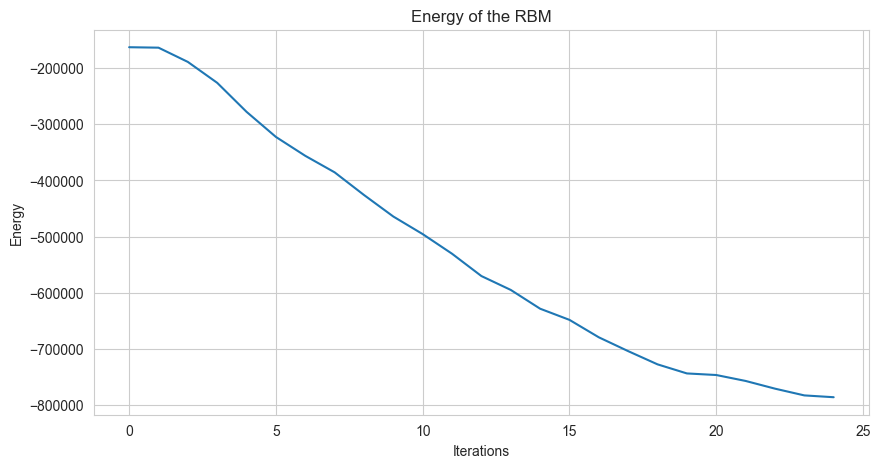

In [7]:
rbm.plot_energy()

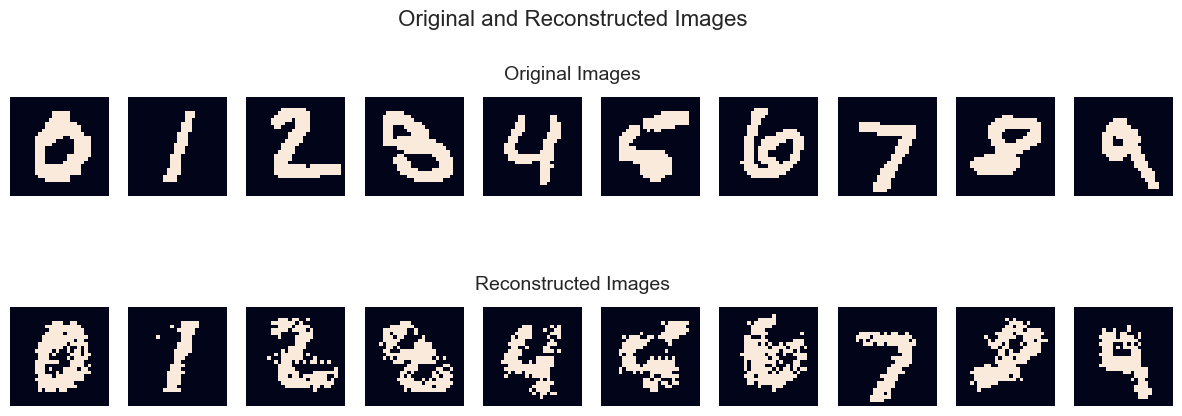

In [8]:
x_test, y_test = mnist('test')
_, indices = np.unique(y_test, return_index=True)
rbm = RestrictedBoltzmannMachine.from_components('model/rbm.npz')
pred = rbm.predict(x_test[indices], plot=True)


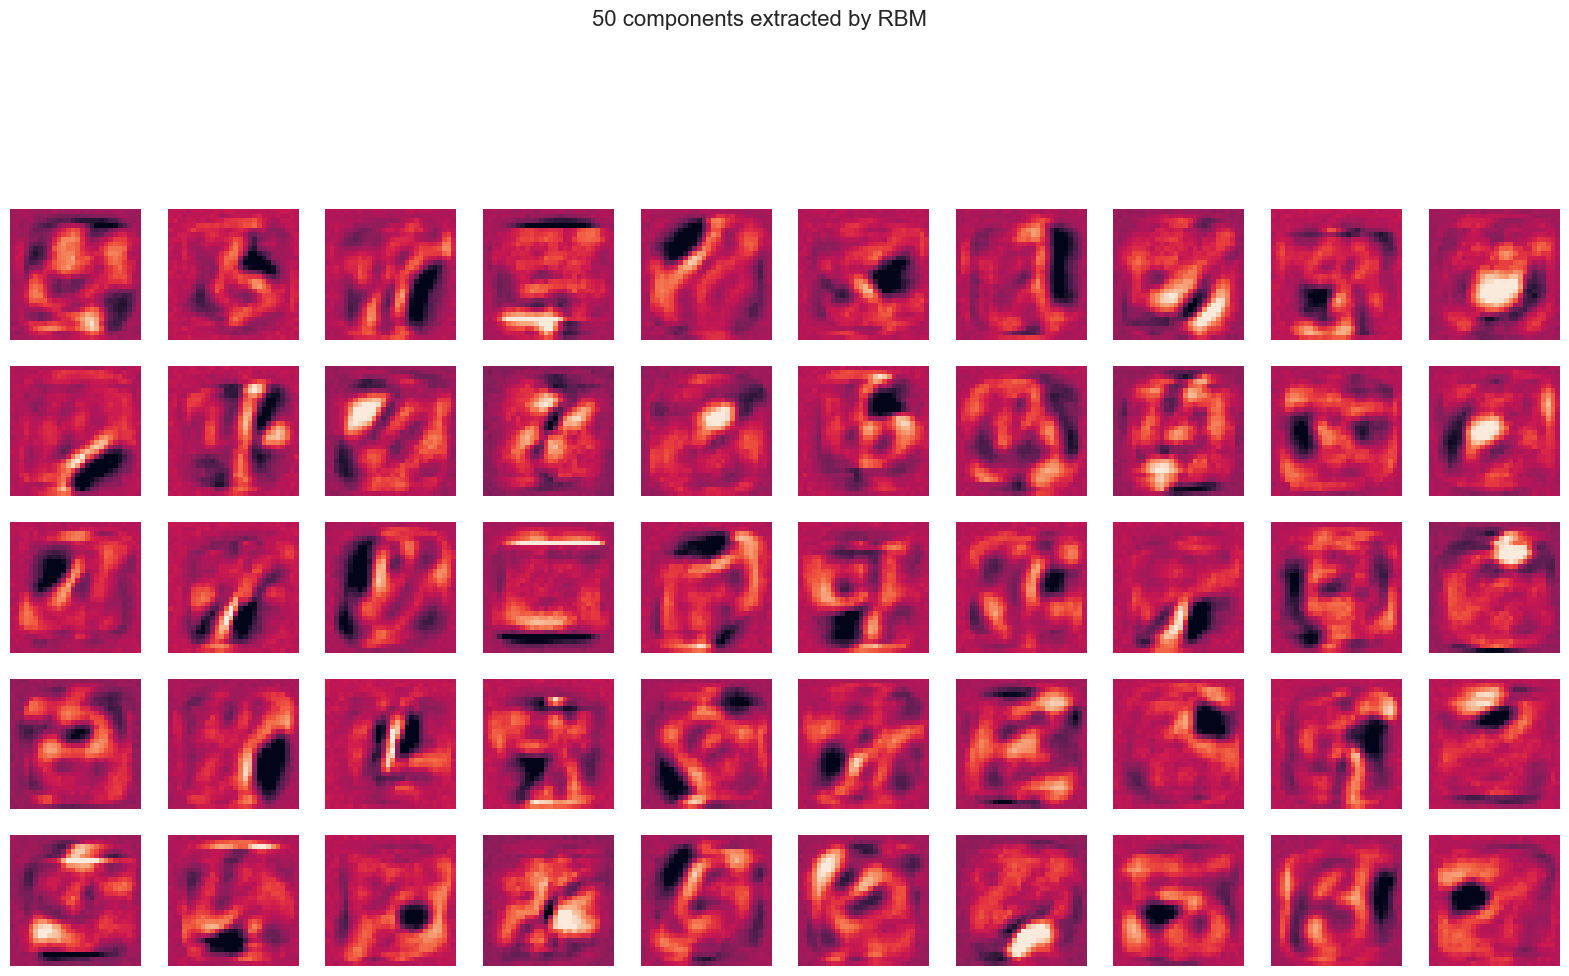

In [9]:
rbm.plot_components()

In [10]:
feed_forward = K.models.Sequential()
feed_forward.add(K.layers.Dense(256, input_dim=50, activation='relu'))
feed_forward.add(K.layers.Dense(128, activation='relu'))
feed_forward.add(K.layers.Dense(64, activation='relu'))
feed_forward.add(K.layers.Dense(10, activation='softmax'))
feed_forward.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
feed_forward.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               13056     
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 10)                650       
                                                                 
Total params: 54858 (214.29 KB)
Trainable params: 54858 (214.29 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
x_train, y_train = mnist('training')
encoded_train = rbm.predict_hidden(x_train)
encoded_test = rbm.predict_hidden(x_test)
x_train, x_val, y_train, y_val = train_test_split(encoded_train, y_train, test_size=0.1, random_state=42)


In [ ]:
feed_forward.fit(
    x_train, 
    y_train, 
    epochs=50, 
    batch_size=100, 
    validation_data=(x_val, y_val),
    callbacks=[
        K.callbacks.EarlyStopping(patience=5, monitor='val_loss'), 
    ],
    verbose=1
)
feed_forward.save('model/feed_forward.h5')

In [ ]:
model = K.models.load_model('model/feed_forward.h5')
res = model.evaluate(encoded_test, y_test)
accuracy = res[1] * 100
print(f'Accuracy: {accuracy:.2f}%')